In [112]:
import os
import numpy as np
import pandas as pd
import pickle
from src.features.build_features import make_final_sets
from src.data.utils import split_features_target
from src.models.utils import plot_max_depth_train_val_scores

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,8)})
# for nice dark theme in Jupyter Notebooks
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
df_train, df_test = make_final_sets()
X_train, y_train = split_features_target(df_train, "mpg")
X_test, y_test = split_features_target(df_test, "mpg")

/Users/Corentin/anaconda3/envs/auto-mpg/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Corentin/anaconda3/envs/auto-mpg/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Corentin/anaconda3/envs/auto-mpg/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
pkl_filename = "../models/pickle_random_forest.pkl"
with open(pkl_filename, 'rb') as file:
    rf = pickle.load(file)

In [22]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("r2 train:", r2_train)
print("r2 test:", r2_test)
print("rmse train", rmse_train)
print("rmse test", rmse_test)


r2 train: 0.9284332298429774
r2 test: 0.9021196797391268
rmse train 2.1182460061278308
rmse test 2.294052469656749


- Test errors on the test set errors even better than validation error. The model improved by training on a larger set.
- The final model can explain 90.21% of variability on the test set and 92.84% on the training set. It doesn't seem to overfit the training set.
- The root mean squarred error is 2.29 mile/galon on the training set and 2.11 mile/galon.

### Test errors 

#### 95% confindence interval

In [35]:
confidence = 0.95
squared_errors = (y_test_pred - y_test) ** 2
ci = np.sqrt(stats.t.interval(confidence,
                              len(squared_errors) -1,
                              loc=squared_errors.mean(),
                              scale=stats.sem(squared_errors)
                             ))
print("95% Confidence Interval: [{:.3f}, {:.3f}]".format(ci[0], ci[1]))

95% Confidence Interval: [1.837, 2.674]


In [33]:
y_test.describe()

count    80.000000
mean     23.142500
std       7.378823
min      10.000000
25%      17.375000
50%      23.000000
75%      27.250000
max      44.000000
Name: mpg, dtype: float64

#### Measured vs Predicted 

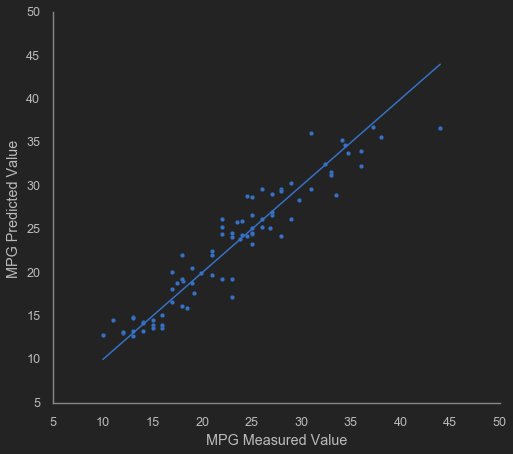

In [52]:
fig, ax = plt.subplots()
min_ = y_test.min()
max_ = y_test.max()
ax.scatter(y_test, y_test_pred)
ax.plot([min_, max_], [min_, max_])
plt.xlabel("MPG Measured Value")
plt.ylabel("MPG Predicted Value")

sns.despine()

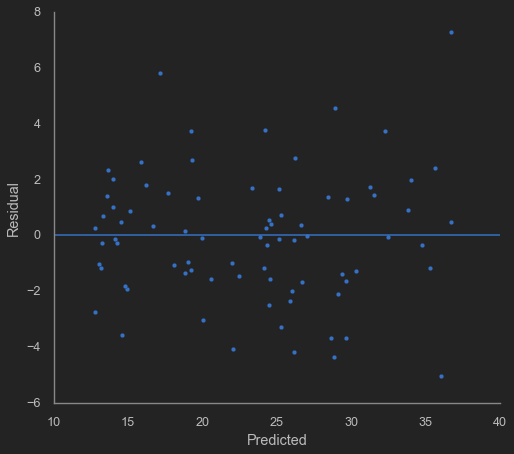

In [64]:
residual = y_test - y_test_predict
plt.scatter(y_test_pred, residual)
plt.tick_params(axis='both', which='major')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
sns.despine()

#### Distribution of residuals

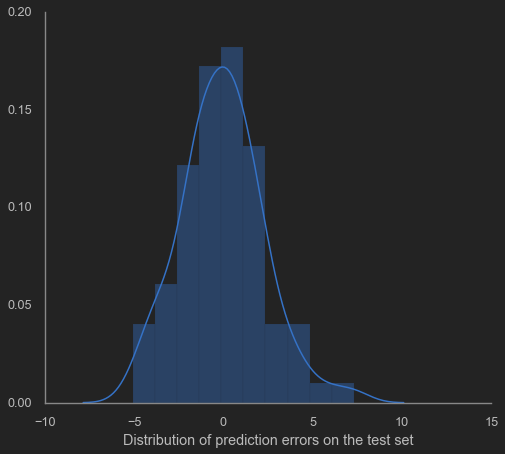

In [60]:
sns.distplot(residual)
plt.xlabel("Distribution of prediction errors on the test set")
sns.despine()

In [142]:
residual.describe()

count    80.000000
mean     -0.052004
std       2.307933
min      -5.046379
25%      -1.474715
50%      -0.073912
75%       1.386552
max       7.292868
Name: mpg, dtype: float64

Residuals are noramlly distributed around 0.
Normality would matter if we used a linear model like Lasso regression. 

We can further check the instance where the errors are the highest and try to understand why the model is making these errors, if for example car contruction experts seek a better predictive power.

For now, we can assume that the model is giving good enough results.

## Would more data improve the model? 

In [124]:
# creat a random forest with the same params than the selected model
rf_lc = RandomForestRegressor().set_params(**rf.get_params())
train_sizes = np.linspace(36, X_train.shape[0], 10, endpoint=True).astype(int)
train_score = []
test_score = []

for m in train_sizes:
    rf_lc.fit(X_train[:m], y_train[:m])
    train_score.append(mean_squared_error(y_train[:m], rf_lc.predict(X_train[:m])))
    test_score.append(mean_squared_error(y_test, rf_lc.predict(X_test)))

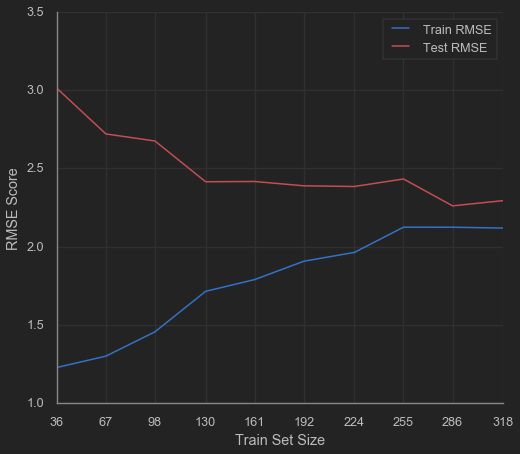

In [139]:
plt.plot(train_sizes, np.sqrt(train_score), "b", label="Train RMSE")
plt.plot(train_sizes, np.sqrt(test_score), "r", label="Test RMSE")

plt.ylabel("RMSE Score")
plt.xlabel("Train Set Size")
plt.xlim(train_sizes.min(), train_sizes.max())
plt.xticks(train_sizes)
plt.grid(True)
plt.legend(loc="best")
sns.despine()